## Preparation of the data and model

#### BA-Shapes, 2 layers 1 head

In [1]:
# Import the utility functions
import torch
from src.experiment_utils import FaithfulnessExperiment, FaithfulnessExperimentAnalysis

device = torch.device("cpu")
dataset_folder = "/workspace/Datasets"
model_folder = "/workspace/Models"

# Load the network data locally (for reproduction)
data = torch.load(f"{dataset_folder}/BA-Shapes.pt").to(device)
# Load model as a whole
model = torch.load(f"{model_folder}/GAT_BAShapes_2L1H.pt").to(device)
model.eval()

with torch.no_grad():
    _  = model(data.x, data.edge_index, return_att = True)
    att = model.att

In [2]:
# Define the experiment
faithfulness_experiment = FaithfulnessExperiment(
    model = model,
    data = data,
    device = device,
    )

faithfulness_experiment.set_target_nodes(
    list(range(300, 700))
)

Target nodes set...
Generating edge lists within 2 hops of target nodes...
...Done


In [3]:
%%timeit 
attribute_dict = faithfulness_experiment.get_attributions(verbose=False)

2.08 s ± 9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
print(f"2.08 s ± 9 ms per loop, {2.08 / 400} s per node")

2.08 s ± 9 ms per loop, 0.0052 s per node


#### BA-Shapes, 3 layers 1 head

In [5]:
# Import the utility functions
import torch

device = torch.device("cpu")
dataset_folder = "/workspace/Datasets"
model_folder = "/workspace/Models"

# Load the network data locally (for reproduction)
data = torch.load(f"{dataset_folder}/BA-Shapes.pt").to(device)
# Load model as a whole
model = torch.load(f"{model_folder}/GAT_BAShapes_3L1H.pt").to(device)
model.eval()

with torch.no_grad():
    _  = model(data.x, data.edge_index, return_att = True)
    att = model.att

In [6]:
# Define the experiment
faithfulness_experiment = FaithfulnessExperiment(
    model = model,
    data = data,
    device = device,
    )

faithfulness_experiment.set_target_nodes(
    list(range(300, 700))
)

Target nodes set...
Generating edge lists within 3 hops of target nodes...
...Done


In [7]:
%%timeit 
attribute_dict = faithfulness_experiment.get_attributions(verbose=False)

/workspace/src/experiment_utils.py:124: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  correction_matrix_dict[0] = torch.sparse.mm(att_matrix_dict[2], att_matrix_dict[1])


17.4 s ± 40.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
print(f"17.4 s ± 40.8 ms per loop, {17.4 / 400} s per node")

17.4 s ± 40.8 ms per loop, 0.0435 s per node


In [11]:
# Now, we have everything that we need to run the experiment on a single target node.
# The experiment is run as follows.
# 1. We select a target node (given as a parameter to the function)
# 2. Get all edges within the target node's k-hop neighborhood
# 3. For all edges in the k-hop neighborhood, we get the attribution scores
# according to ATTATTRIBUTE, ATTATTRIBUTE_sim, and AVGATT.
# 4. Now, get the 1) label 2) prediction 3) prediction probability 4) entropy values of the original model
# 5. Now, we mask each edge acquired in step 2, and get the 1) label 2) prediction 3) prediction probability 4) entropy values
# by masking the edge.
# 6. Compare the importance ranking between the three scores in step 3 and the change in the values in step 5.
# Just do this for one target node for now.

# Import the utility functions
from torch_geometric.utils import get_num_hops, get_num_hops
from typing import Tuple

import torch
from src.attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
    get_ATTATTTRIBUTE_edge,
    get_AVGATT_edge,
    return_edges_in_k_hop,
)
from torch_geometric.utils import get_num_hops
from typing import Tuple
from torch_geometric.utils import degree

def get_edge_scores(
    target_edge: Tuple, comp_graph, comp_graph_new, layer_att_dict, att
):
    assert type(target_edge) == tuple, "target_edge must be a tuple"
    # Get ATTATTRIBUTE & ATTATTRIBUTE_sim scores
    attattribute, attattribute_sim = get_ATTATTTRIBUTE_edge(
        comp_graph=comp_graph,
        comp_graph_new=comp_graph_new,
        layer_att_dict=layer_att_dict,
        target_edge=target_edge,
        verbose=False,
    )
    # Get AVGATT scores
    avgatt = get_AVGATT_edge(att=att, edge=target_edge)

    return attattribute, attattribute_sim, avgatt



# Let's refactor tha code below as a function
def experiment_on_target_node_simplified(
    target_idx: int, data, model, self_loops=True, verbose=False
):
    # 2. Get all edges within the target node's k-hop neighborhood
    edge_lists = return_edges_in_k_hop(
        data=data, target_idx=target_idx, hop=2, self_loops=self_loops
    )
    if verbose:
        print(f"Number of edges in the k-hop neighborhood: {len(edge_lists)}")

    # 3. For all edges in the k-hop neighborhood, we get the attribution scores
    # according to ATTATTRIBUTE, ATTATTRIBUTE_sim, and AVGATT.
    # First, prepare ingredients for analysis

    num_layers = get_num_hops(model)
    att_dict_raw = get_attention_raw_dict(model, data)
    att_dict = process_attention_dict(att_dict_raw)
    comp_graph = get_computation_graph(
        edge_index=data.edge_index, k=num_layers, target_idx=target_idx
    )
    (
        nodes_per_level_original,
        num_nodes_per_level,
        true_node_label,
    ) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
    nodes_per_level_new = reindex_nodes_per_level(
        nodes_per_level_original, num_nodes_per_level
    )
    comp_graph_new = translate_comp_graph(
        comp_graph=comp_graph,
        nodes_per_level_new=nodes_per_level_new,
        nodes_per_level_original=nodes_per_level_original,
        degree=degree(data.edge_index[0]),
    )
    layer_att_dict = get_att_dict_per_layer(
        comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
    )

    # 4. Now, get the 1) label 2) prediction 3) prediction probability 4) entropy values of the original model
    # Output without any masking
    with torch.no_grad():
        _ = model(
            x=data.x, edge_index=data.edge_index, return_att=True, mask_edge=None
        )
        att = model.att
    # Get results for all edges in the k-hop neighborhood
    attattribute_list, attattribute_sim_list, avgatt_list = [], [], []
    for current_edge in edge_lists:
        attattribute, attattribute_sim, avgatt = get_edge_scores(
            target_edge=tuple(current_edge),
            comp_graph=comp_graph,
            comp_graph_new=comp_graph_new,
            layer_att_dict=layer_att_dict,
            att=att,
        )
        attattribute_list.append(attattribute)
        attattribute_sim_list.append(attattribute_sim)
        avgatt_list.append(avgatt)

def experiment_on_batch_node_wrapper(list_target_idx, data, model):
    for target_idx in list_target_idx:
        experiment_on_target_node_simplified(target_idx=target_idx, data=data, model=model, self_loops=True, verbose=False)

### BA-shapes, 2 layers 1 head

In [13]:
# Import the utility functions
import torch

device = torch.device("cpu")
dataset_folder = "/workspace/Datasets"
model_folder = "/workspace/Models"

# Load the network data locally (for reproduction)
data = torch.load(f"{dataset_folder}/BA-Shapes.pt").to(device)
# Load model as a whole
model = torch.load(f"{model_folder}/GAT_BAShapes_2L1H.pt").to(device)
model.eval()

with torch.no_grad():
    _  = model(data.x, data.edge_index, return_att = True)
    att = model.att

In [14]:
%%timeit
experiment_on_batch_node_wrapper(list_target_idx=list(range(300, 700)), data=data, model=model)

3min 36s ± 1.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### BA-shapes, 3 layers 1 head

In [15]:
# Import the utility functions
import torch

device = torch.device("cpu")
dataset_folder = "/workspace/Datasets"
model_folder = "/workspace/Models"

# Load the network data locally (for reproduction)
data = torch.load(f"{dataset_folder}/BA-Shapes.pt").to(device)
# Load model as a whole
model = torch.load(f"{model_folder}/GAT_BAShapes_3L1H.pt").to(device)
model.eval()

with torch.no_grad():
    _  = model(data.x, data.edge_index, return_att = True)
    att = model.att

In [16]:
%%timeit
experiment_on_batch_node_wrapper(list_target_idx=list(range(300, 700)), data=data, model=model)

5min 23s ± 1.58 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Code for runnint experiments (do not run these cell unless re-experimenting)

/tmp/ipykernel_570993/2158014836.py:46: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 600])


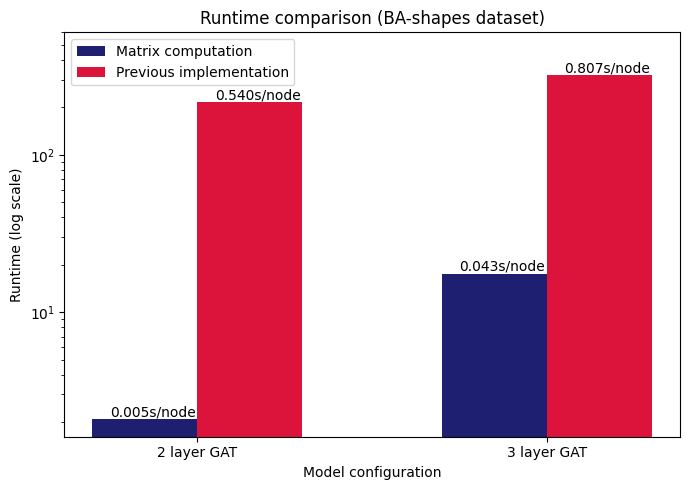

In [60]:
import numpy as np
import matplotlib.pyplot as plt

tot_runtime_2L1H = 2.08
tot_runtime_3L1H = 17.4

runtime_per_node_2L1H = tot_runtime_2L1H / 400
runtime_per_node_3L1H = tot_runtime_3L1H / 400

tot_runtime_2L1H_old = 3 * 60 + 36
tot_runtime_3L1H_old = 5 * 60 + 23

runtime_per_node_2L1H_old = tot_runtime_2L1H_old / 400
runtime_per_node_3L1H_old = tot_runtime_3L1H_old / 400

# Use colors #1e1f71 and #dc143c

# Figure size
plt.figure(figsize=(7,5), dpi= 100)

ind = np.arange(2)  # the x locations for the groups

blue_bar = [tot_runtime_2L1H, tot_runtime_3L1H]
red_bar = [tot_runtime_2L1H_old, tot_runtime_3L1H_old]

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='Matrix computation', color = '#1e1f71')
plt.bar(ind + width, red_bar, width, label='Previous implementation', color = '#dc143c')

# Display runtime per node as text on top of the bars
plt.text(x = -0.1 , y = tot_runtime_2L1H + 0.1, s = f"{runtime_per_node_2L1H:.3f}s/node", size = 10)
plt.text(x = 0.2 , y = tot_runtime_2L1H_old + 10, s = f"{runtime_per_node_2L1H_old:.3f}s/node", size = 10)

plt.text(x = 0.9 , y = tot_runtime_3L1H + 1, s = f"{runtime_per_node_3L1H:.3f}s/node", size = 10)
plt.text(x = 1.2 , y = tot_runtime_3L1H_old + 10, s = f"{runtime_per_node_3L1H_old:.3f}s/node", size = 10)

plt.xlabel('Model configuration')
plt.ylabel('Runtime (log scale)')
plt.title('Runtime comparison (BA-shapes dataset)')
plt.xticks(ind + width / 2, ('2 layer GAT', '3 layer GAT'))
# Make y-axis log scale
plt.yscale('log')
plt.ylim([0, 600])

# Create legend at top left
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [59]:
runtime_per_node_2L1H

0.0052